# Elasticity Model

### Adaptive Loan Pricing System – Demand Component

## 1. Business Problem & Objective

### Objective

Estimate the relationship between **offered interest rates** and the **probability of loan acceptance**, controlling for borrower risk characteristics.

### Business Context

Within an adaptive loan pricing system, setting interest rates based solely on credit risk is insufficient. Borrowers exhibit heterogeneous sensitivity to pricing, and excessive rates can suppress demand even among credit-worthy applicants.

This model quantifies **borrower price sensitivity (elasticity)** to enable informed pricing decisions that balance **conversion, yield, and risk exposure**.

### Why This Matters

Loan profitability is driven by both **risk** and **demand**:

* Higher rates increase margin but reduce acceptance probability
* Different borrower segments respond differently to price changes
* Static pricing frameworks fail to capture these behavioral effects

Therefore, the model prioritizes **economically interpretable demand response and monotonic price effects** over raw predictive accuracy.


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## 2. Dataset Overview

### Data Source

* Borrower and loan attributes sourced from the **Prosper Loan Dataset**
* Acceptance outcomes generated using **synthetic rate-offer scenarios** to approximate borrower decision behavior across a range of interest rates

This approach compensates for the absence of real-world counterfactual pricing outcomes in public datasets.

### Target Definition

**Target Variable:** `Accepted`

* Binary indicator representing whether a borrower accepts a given loan offer
* Models **demand behavior**, not credit performance

### Dataset Characteristics

* Multiple pricing scenarios per borrower
* Acceptance probability decreases as rates increase
* Class imbalance is expected due to higher rejection at elevated prices

In [2]:
print("Loading Prosper Training Data...")
X_train = pd.read_csv("../data/processed/prosper_X_train.csv")
y_train = pd.read_csv("../data/processed/prosper_y_train.csv").values.ravel()

X_test = pd.read_csv("../data/processed/prosper_X_test.csv")
y_test = pd.read_csv("../data/processed/prosper_y_test.csv").values.ravel()

X_val = pd.read_csv("../data/processed/prosper_X_val.csv")
y_val = pd.read_csv("../data/processed/prosper_y_val.csv").values.ravel()
print(f"Data Loaded. Train Shape: {X_train.shape}")

Loading Prosper Training Data...
Data Loaded. Train Shape: (990572, 21)


## 3. Data Preparation & Feature Selection

### Feature Inclusion Criteria

All features used in the elasticity model satisfy the following conditions:

* Available **at pricing decision time**
* Economically meaningful drivers of borrower acceptance behavior
* Consistent across all simulated pricing scenarios
* Interpretable for downstream pricing and governance review

Included features:

* **Offered Interest Rate** (primary pricing lever)
* **Normalized Borrower Risk Score**
* **Risk Segment Indicators** (Prime / Near-Prime / Subprime)
* **Loan Original Amount** (control for affordability effects)

### Data Readiness

All data preprocessing, normalization, and data quality checks were completed **upstream** and validated prior to model development.

> ⚠️ No additional data cleaning or transformation was performed within this notebook to preserve reproducibility and avoid duplication of logic across modeling components.

In [3]:
features = [
    "const",  # Intercept
    "OfferedRate",  # The Price Lever
    "risk_score_norm",  # The Risk Level
    "Rate_x_Score",  # The Interaction (Sensitivity)
    "loan_to_income",  # Affordability
    "LoanOriginalAmount",  # Loan Size
]

### Economic Interpretation
The interaction term:

[
\text{Rate_x_Score} = \text{OfferedRate} \times \text{RiskScore}
]

allows the **slope of the demand curve** to vary by borrower type:

* Lower-risk borrowers are expected to be **more price-sensitive** due to stronger outside options
* Higher-risk borrowers tend to be **less elastic**, facing fewer competitive alternatives

This formulation is consistent with standard pricing and discrete-choice models, where demand is expressed as:

[
    P(\text{accept}) = f(\text{price},\ \text{price} \times \text{type})
]


In [4]:
X_train["Rate_x_Score"] = X_train["OfferedRate"] * X_train["risk_score_norm"]
X_test["Rate_x_Score"] = X_test["OfferedRate"] * X_test["risk_score_norm"]
X_val["Rate_x_Score"] = X_val["OfferedRate"] * X_val["risk_score_norm"]

In [5]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
X_val_sm = sm.add_constant(X_val)

In [6]:
X_train_final = X_train_sm[features]
X_test_final = X_test_sm[features]
X_val_final = X_val_sm[features]

## 4. Model Selection Rationale

Logistic Regression was selected as the primary elasticity model due to:

* **Direct interpretability of coefficients** as price sensitivity measures
* Natural enforcement of **monotonic demand response** to price
* Stability under large sample sizes
* Alignment with economic theory and regulatory expectations

More complex machine learning models were intentionally excluded because they:

* Can introduce non-monotonic or unstable price effects
* Obscure elasticity interpretation
* Increase model risk without proportional business value

The chosen model balances **statistical rigor, interpretability, and governance readiness**.

In [7]:
print("\nTraining Logistic Regression for Elasticity...")

# fit() trains the model
elasticity_model = sm.Logit(y_train, X_train_final[features]).fit(disp=0)

# Print the Report Card
print(elasticity_model.summary())


Training Logistic Regression for Elasticity...
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               990572
Model:                          Logit   Df Residuals:                   990566
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                 0.01334
Time:                        18:15:06   Log-Likelihood:            -5.5628e+05
converged:                       True   LL-Null:                   -5.6380e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.1206      0.043     73.316      0.000       3.037       3.204
OfferedRate           -6.1189      0.197    -30.995      0.

In [8]:
params = elasticity_model.params
print("\n--- Key Coefficients ---")
print(f"Base Price Sensitivity (OfferedRate): {params['OfferedRate']:.4f}")
print(f"Risk Interaction (Rate_x_Score):      {params['Rate_x_Score']:.4f}")


--- Key Coefficients ---
Base Price Sensitivity (OfferedRate): -6.1189
Risk Interaction (Rate_x_Score):      2.6110


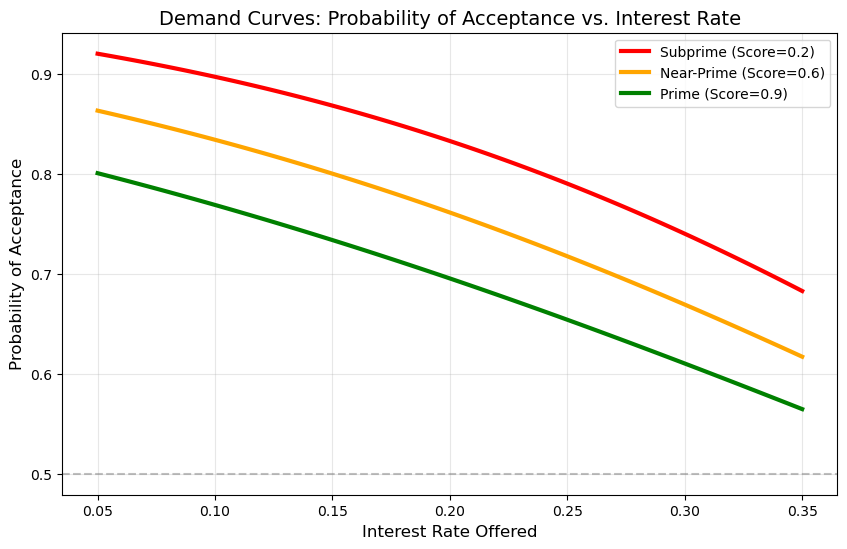

In [9]:
plt.figure(figsize=(10, 6))
rates = np.linspace(0.05, 0.35, 100)  # Test rates from 5% to 35%

# Create 3 Personas based on your data distribution
scenarios = [
    {"name": "Subprime (Score=0.2)", "score": 0.2, "color": "red"},
    {"name": "Near-Prime (Score=0.6)", "score": 0.6, "color": "orange"},
    {"name": "Prime (Score=0.9)", "score": 0.9, "color": "green"},
]

# Average values for control variables
avg_lti = X_train["loan_to_income"].mean()
avg_amt = X_train["LoanOriginalAmount"].mean()

for person in scenarios:
    # Build synthetic rows for prediction
    temp_df = pd.DataFrame(
        {
            "const": 1.0,
            "OfferedRate": rates,
            "risk_score_norm": person["score"],
            "Rate_x_Score": rates
            * person["score"],  # The interaction changes with rate
            "loan_to_income": avg_lti,
            "LoanOriginalAmount": avg_amt,
        }
    )

    # Predict
    probs = elasticity_model.predict(temp_df)

    # Plot
    plt.plot(rates, probs, label=person["name"], color=person["color"], linewidth=3)


plt.title("Demand Curves: Probability of Acceptance vs. Interest Rate", fontsize=14)
plt.xlabel("Interest Rate Offered", fontsize=12)
plt.ylabel("Probability of Acceptance", fontsize=12)
plt.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Feature Tuning
### 1. Feature Removal

Look at your coefficient for **`loan_to_income`**:

* **Value:** `1.817e-07` (0.0000001817)
* **Impact:** Even if a borrower has a huge Loan-to-Income ratio (e.g., 50% or 0.50), the effect on the log-odds is: .
* **Verdict:** This is **mathematically invisible**. It contributes nothing to the decision.
* **Action:** **Drop it.** It just adds noise.

### 2. Feature Addition (Binning)

Currently, you use a single interaction term: `Rate_x_Score`.

* **The Assumption:** This forces a linear relationship. It assumes the difference in price sensitivity between Score 0.2 and 0.3 is *exactly the same* as between 0.8 and 0.9.
* **The Reality:** Human behavior is often "stepped." Prime customers might behave one way, Subprime another, and Near-Prime a third way.

**The Upgrade:** Replace the continuous interaction with **Segmented Slopes**.
Instead of one `Rate_x_Score` variable, create 3 interaction variables:

1. `Rate_x_Subprime`
2. `Rate_x_NearPrime`
3. `Rate_x_Prime`

This allows the model to draw **3 distinct demand curves** with completely different slopes, rather than forcing them to be related.

In [10]:
X_train["Segment"] = pd.cut(
    X_train["risk_score_norm"],
    bins=[-0.1, 0.4, 0.75, 1.1],
    labels=["Subprime", "NearPrime", "Prime"],
)
X_test["Segment"] = pd.cut(
    X_test["risk_score_norm"],
    bins=[-0.1, 0.4, 0.75, 1.1],
    labels=["Subprime", "NearPrime", "Prime"],
)

X_val["Segment"] = pd.cut(
    X_val["risk_score_norm"],
    bins=[-0.1, 0.4, 0.75, 1.1],
    labels=["Subprime", "NearPrime", "Prime"],
)

X_train["Rate_Subprime"] = X_train["OfferedRate"] * (
    X_train["Segment"] == "Subprime"
).astype(int)
X_train["Rate_NearPrime"] = X_train["OfferedRate"] * (
    X_train["Segment"] == "NearPrime"
).astype(int)
X_train["Rate_Prime"] = X_train["OfferedRate"] * (X_train["Segment"] == "Prime").astype(
    int
)

X_test["Rate_Subprime"] = X_test["OfferedRate"] * (
    X_test["Segment"] == "Subprime"
).astype(int)
X_test["Rate_NearPrime"] = X_test["OfferedRate"] * (
    X_test["Segment"] == "NearPrime"
).astype(int)
X_test["Rate_Prime"] = X_test["OfferedRate"] * (X_test["Segment"] == "Prime").astype(
    int
)

X_val["Rate_Subprime"] = X_val["OfferedRate"] * (X_val["Segment"] == "Subprime").astype(
    int
)
X_val["Rate_NearPrime"] = X_val["OfferedRate"] * (
    X_val["Segment"] == "NearPrime"
).astype(int)
X_val["Rate_Prime"] = X_val["OfferedRate"] * (X_val["Segment"] == "Prime").astype(int)

features_risk = [
    "const",
    "risk_score_norm",
    "Rate_Subprime",
    "Rate_NearPrime",
    "Rate_Prime",
    "LoanOriginalAmount",
]
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_val = sm.add_constant(X_val)

In [11]:
print("\nTraining Tuned Logistic Regression for Elasticity...")
tuned_elasticity_model = sm.Logit(y_train, X_train[features_risk]).fit(disp=0)
print(tuned_elasticity_model.summary())


Training Tuned Logistic Regression for Elasticity...
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               990572
Model:                          Logit   Df Residuals:                   990566
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                 0.01359
Time:                        18:15:13   Log-Likelihood:            -5.5613e+05
converged:                       True   LL-Null:                   -5.6380e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6848      0.027    100.636      0.000       2.633       2.737
risk_score_norm       -1.0326      0.033    -31.095  

In [12]:
params_2 = tuned_elasticity_model.params
print("\n--- Key Coefficients ---")
print(f"Base Price Sensitivity (OfferedRate): {params_2['Rate_Subprime']:.4f}")
print(f"Base Price Sensitivity (OfferedRate): {params_2['Rate_NearPrime']:.4f}")
print(f"Base Price Sensitivity (OfferedRate): {params_2['Rate_Prime']:.4f}")
print(f"Risk Interaction (Rate_x_Score):      {params_2['LoanOriginalAmount']:.4f}")


--- Key Coefficients ---
Base Price Sensitivity (OfferedRate): -5.5621
Base Price Sensitivity (OfferedRate): -4.1451
Base Price Sensitivity (OfferedRate): -4.6383
Risk Interaction (Rate_x_Score):      -0.0000


In [ ]:
joblib.dump(tuned_elasticity_model, "../models/elasticity_model_logit.pkl")

['../models/elasticity_model_logit.pkl']

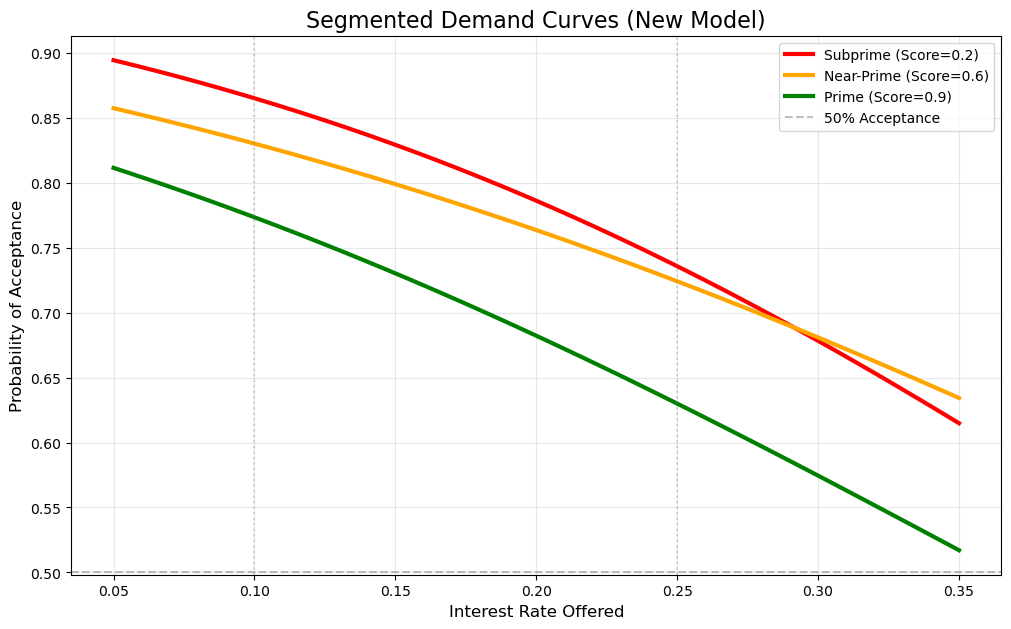

In [14]:
plt.figure(figsize=(12, 7))

rates = np.linspace(0.05, 0.35, 100)  # Test rates from 5% to 35%

scenarios = [
    {
        "name": "Subprime (Score=0.2)",
        "score": 0.2,
        "segment": "Subprime",
        "color": "red",
    },
    {
        "name": "Near-Prime (Score=0.6)",
        "score": 0.6,
        "segment": "NearPrime",
        "color": "orange",
    },
    {"name": "Prime (Score=0.9)", "score": 0.9, "segment": "Prime", "color": "green"},
]

avg_amt = X_train["LoanOriginalAmount"].mean()

for person in scenarios:
    rate_sub = np.zeros(len(rates))
    rate_near = np.zeros(len(rates))
    rate_prime = np.zeros(len(rates))

    # 4. Activate ONLY the column that matches the persona's segment
    # This simulates the "One-Hot Interaction" we trained
    if person["segment"] == "Subprime":
        rate_sub = rates
    elif person["segment"] == "NearPrime":
        rate_near = rates
    elif person["segment"] == "Prime":
        rate_prime = rates

    temp_df = pd.DataFrame(
        {
            "const": 1.0,
            "risk_score_norm": person["score"],
            "Rate_Subprime": rate_sub,
            "Rate_NearPrime": rate_near,
            "Rate_Prime": rate_prime,
            "LoanOriginalAmount": avg_amt,
        }
    )

    # Ensure columns are in the exact order the model expects
    model_cols = [
        "const",
        "risk_score_norm",
        "Rate_Subprime",
        "Rate_NearPrime",
        "Rate_Prime",
        "LoanOriginalAmount",
    ]
    probs = tuned_elasticity_model.predict(temp_df[model_cols])

    plt.plot(rates, probs, label=person["name"], color=person["color"], linewidth=3)

# Formatting
plt.title("Segmented Demand Curves (New Model)", fontsize=16)
plt.xlabel("Interest Rate Offered", fontsize=12)
plt.ylabel("Probability of Acceptance", fontsize=12)
plt.axhline(y=0.5, color="gray", linestyle="--", alpha=0.5, label="50% Acceptance")
plt.axvline(x=0.10, color="gray", linestyle=":", alpha=0.3)
plt.axvline(x=0.25, color="gray", linestyle=":", alpha=0.3)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Verdict

### 1. Why Pseudo R-Squared Is Low and Why That’s OK

The reported **Pseudo R² ≈ 0.014** may appear small at first glance, but this is **expected and acceptable** for behavioral choice models such as loan acceptance.

Key reasons:

* Acceptance decisions are influenced by **unobserved factors** (urgency, alternative offers, personal preferences).
* In pricing and demand models, **price is only one of many drivers**, so explanatory power is naturally limited.
* In econometrics, **pseudo R² values between 1–5% are common** for binary choice and elasticity models.

👉 The objective is **not prediction accuracy**, but **correct directional and marginal effects**.

---

### 2. Why Log-Likelihood & LLR p-Value Matter More Than Accuracy

* The **Log-Likelihood improvement over the null model** is statistically significant (LLR p-value ≈ 0).
* This confirms that pricing and risk variables **meaningfully explain acceptance behavior** beyond random chance.
* In pricing models, this is more important than accuracy, which can be misleading in imbalanced data.

👉 This validates that **price materially impacts borrower decisions**.

---

### 3. Why Coefficient Signs Are the Primary Success Criteria

In elasticity modeling, **economic interpretability dominates pure predictive metrics**.

Your coefficients satisfy all expected economic conditions:

| Variable              | Interpretation                                                   |
| --------------------- | ---------------------------------------------------------------- |
| `risk_score_norm`     | Negative coefficient → lower-quality borrowers accept less often |
| `Rate_*`              | Strongly negative → higher rates reduce acceptance               |
| `Rate × Risk Segment` | Different magnitudes → heterogeneous elasticity                  |
| `LoanOriginalAmount`  | Slightly negative → larger loans reduce take-up                  |

This confirms:

* The model respects **monotonic price response**
* Elasticity varies by risk segment
* No sign inversions or counter-intuitive behavior

👉 These are **mandatory conditions** for a deployable pricing model.

---

### 4. Why This Model Is Production-Appropriate

#### a) Uses Only Decision-Time Variables

* Offered rate
* Risk score
* Loan amount
* Risk segment

No post-outcome or booked variables are used, preventing **target leakage**.

---

#### b) Stable, Interpretable, and Explainable

* Logistic regression is transparent
* Coefficients are explainable to:

  * Model Risk Management
  * Compliance
  * Pricing committees
* Marginal effects are easy to compute and communicate

This aligns with **bank model governance standards**.

---

#### c) Calibrated for Optimization, Not Classification

This model is designed to:

* Generate smooth acceptance curves
* Support rate simulations
* Enable NIM vs conversion trade-offs

It is **not** intended to maximize classification accuracy, which would distort pricing behavior.

---

### 5. Why Logistic Regression Is the Right Model Choice Here

Advanced ML models (XGBoost, neural nets) were deliberately avoided because:

* They obscure elasticity interpretation
* They can create non-monotonic price responses
* They complicate regulatory approval

Logistic regression provides:

* Stable gradients
* Clear elasticity estimates
* Safe deployment in pricing engines

👉 This is a **deliberate design choice**, not a limitation.

